<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2023<br>
<font color=3C99D size=5>
    Practical Assignment 3 - Reinforcement Learning <br>
<font color=696880 size=4>
    Hossein Goli

____

## Gym OpenAI Environments
`gym` is a library developed by OpenAI that provides a suite of environments for developing and comparing reinforcement learning algorithms. Each environment has a well-defined observation space and action space, as well as a reset function that returns the environment to its initial state.

The main steps involved in training an agent in a `gym` environment are:

1. Initialize the environment
2. Reset the environment to its initial state
3. Take an action in the current state
4. Observe the new state and reward
5. Update the agent's policy based on the observed reward and new state
6. Repeat steps 3 to 5 until the environment returns a "done" signal

Once the agent has learned a good policy, it can be evaluated by running it in the environment for several episodes and measuring its average reward.

### FrozenLake environment
The `FrozenLake-v1` environment is a variant of the classic reinforcement learning problem where the agent must navigate a grid while avoiding obstacles. 

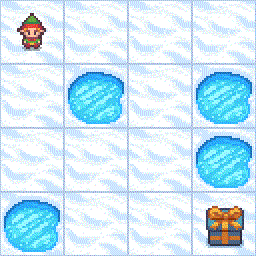


* **Observation Space:** The observation space of the environment is a grid representing the state of the lake.
* **Action Space:** The agent has four possible actions at each time step: move up, move down, move left, or move right.
* **Goal:** The goal of the agent is to reach the goal state while avoiding holes in the ice.
* **Reward:** Reach goal(G): +1 , Reach hole(H): 0 , Reach frozen(F): 0
* **Episode Termination:** The environment signals the end of an episode with a "done" signal.


In [7]:
import numpy as np
import random
from tqdm.notebook import tqdm
import gymnasium as gym
from IPython.display import HTML
from base64 import b64encode
import imageio

In [8]:
#We first create our enviroment
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode='rgb_array')

In [9]:
# ## comment this part if your not using google colab
# from pyvirtualdisplay import Display
# virtual_display = Display(visible=0, size=(1400, 900))
# virtual_display.start()
# ######################

def record_video(env, Qtable, out_directory, fps=1, random_action=False, max_steps=100):
    images = []  
    done = False
    truncated = False
    state, info = env.reset()
    #state = discretize_state(state)
    img = env.render()
    images.append(img)
    total_reward = 0
    i = 0
    while not done and not truncated:
        i += 1
        if i > max_steps:
            break
        action = np.random.randint(4) if random_action else np.argmax(Qtable[state])
        state, reward, done, truncated, info = env.step(action)
        total_reward += reward
        #state = discretize_state(state)
        img = env.render()
        images.append(img)
        if not random_action:
            print(f"action: {action}, state: {state}, reward: {reward}, done: {done}, truncated: {truncated}, info: {info}")
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)
    return total_reward

def show_video(video_path, video_width = 600):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [10]:
total_reward = record_video(env, None, 'frozenlake_random.mp4', fps=5, random_action=True)
print(f"total reward: {total_reward}")
show_video('frozenlake_random.mp4', video_width = 600)

total reward: 0.0


## Q Learning

In [11]:
def epsilon_greedy_policy(q_table, state, epsilon):
    """
    This function implements the epsilon greedy policy. It takes the q_table, the current state and the epsilon value as input and returns an action.
    Inputs:
        q_table: the q_table ndarray
        state: the current state of the agent
        epsilon: the epsilon value
    Outputs:
        action: an action according to the epsilon greedy policy
    """
    ####
    random_value = np.random.uniform(0, 1)

    if random_value < epsilon:
        # Choose a random action with probability epsilon
        action = np.random.choice(q_table.shape[1])
    else:
        # Choose the action with the highest Q-value for the current state with probability 1 - epsilon
        action = np.argmax(q_table[state, :])
    return action

In [12]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  episode_rewards = []
  for episode in tqdm(range(n_training_episodes)):
    # Adjust epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, info = env.reset()
    episode_step = 0
    done = False

    episode_reward = 0
    # repeat
    for step in range(max_steps):
      action = epsilon_greedy_policy(Qtable, state, epsilon)
      next_state, reward, terminated, truncated, info = env.step(action)
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[next_state]) - Qtable[state][action])
      state = next_state

      episode_reward += reward
      episode_step += 1
      if terminated:
        break
    episode_rewards.append(episode_reward)

  return Qtable, episode_rewards

In [13]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
n_eval_episodes = 10_000
learning_rate = 0.08           # Learning rate

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 1e-3            # Exponential decay rate for exploration prob

In [14]:
def initialize_q_table(env):
  return np.zeros((env.observation_space.n, env.action_space.n))

In [15]:
Qtable = initialize_q_table(env)
Qtable_trained, _ = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
record_video(env, Qtable_trained, 'frozenlake_random.mp4', fps=5, random_action=False)
show_video('frozenlake_random.mp4', video_width = 600)

action: 0, state: 0, reward: 0.0, done: False, truncated: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, truncated: False, info: {'prob': 0.3333333333333333}
action: 0, state: 8, reward: 0.0, done: False, truncated: False, info: {'prob': 0.3333333333333333}
action: 3, state: 9, reward: 0.0, done: False, truncated: False, info: {'prob': 0.3333333333333333}
action: 1, state: 13, reward: 0.0, done: False, truncated: False, info: {'prob': 0.3333333333333333}
action: 2, state: 13, reward: 0.0, done: False, truncated: False, info: {'prob': 0.3333333333333333}
action: 2, state: 9, reward: 0.0, done: False, truncated: False, info: {'prob': 0.3333333333333333}
action: 1, state: 8, reward: 0.0, done: False, truncated: False, info: {'prob': 0.3333333333333333}
action: 3, state: 4, reward: 0.0, done: False, truncated: False, info: {'prob': 0.3333333333333333}
action: 0, state: 8, reward: 0.0, done: False, truncated: False, info: {'prob': 0.3333333333333333

In [17]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
env.reset()
env.render()

# Training parameters
n_training_episodes = 10000  # Total training episodes
n_eval_episodes = 10_000
learning_rate = 0.08           # Learning rate

# Environment parameters
max_steps = 200               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 1e-3            # Exponential decay rate for exploration prob

Qtable = initialize_q_table(env)
Qtable_trained_QL, episode_rewards_QL = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
record_video(env, Qtable_trained_QL, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)


action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 25, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 26, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 27, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 28, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 29, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 30, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 31, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 32, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 33, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 34, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 35, reward: -1, done: False, truncated: False, 

# Noisy Cliff

In [20]:
class NoisyCliffWalking(gym.Env):
    def __init__(self, map_name="4x12", render_mode='rgb_array', noise=0.1):
        self.env = gym.make("CliffWalking-v0", render_mode=render_mode)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.noise = noise

    def reset(self):
        return self.env.reset()

    def step(self, action):
        if random.uniform(0, 1) < self.noise:
            return self.env.step(self.action_space.sample())
        else:
            return self.env.step(action)
    
    def render(self):
        return self.env.render()

env = NoisyCliffWalking(map_name="4x12", render_mode='rgb_array', noise=0.3)

In [21]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
n_eval_episodes = 10_000
learning_rate = 0.08           # Learning rate

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 1e-3            # Exponential decay rate for exploration prob

In [22]:
q_table = initialize_q_table(env)
q_table_trained_QL, episode_rewards_QL = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)
record_video(env, q_table_trained_QL, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)

  0%|          | 0/10000 [00:00<?, ?it/s]

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 36, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 12, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 1, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 2, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 3, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 4, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 5, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 4, reward: -1, done: False, truncated: False, info: {'

In [23]:
# Training parameters
env = NoisyCliffWalking(map_name="4x12", render_mode='rgb_array', noise=0.05)

n_training_episodes = 10000  # Total training episodes
n_eval_episodes = 10_000
learning_rate = 0.08           # Learning rate

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 1                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 1e-3            # Exponential decay rate for exploration prob

In [24]:
q_table = initialize_q_table(env)
q_table_trained_QLw, episode_rewards_QLw = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [25]:
record_video(env, q_table_trained_QLw, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 12, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 13, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 14, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 15, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 16, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 17, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 18, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 19, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 20, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 21, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 22, reward: -1, done: False, truncated: False, 

In [26]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
n_eval_episodes = 10_000
learning_rate = 0.08           # Learning rate

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.1                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 1e-3            # Exponential decay rate for exploration prob

In [27]:
q_table = initialize_q_table(env)
q_table_trained_QLw, episode_rewards_QLw = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
record_video(env, q_table_trained_QLw, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 12, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 1, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 2, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 1, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 2, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 1, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 2, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 1, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 2, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 3, state: 1, reward: -1, done: False, truncated: False, info: {'pr

In [ ]:
#SARSA
def train_sarsa(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    episode_rewards = []
    for episode in tqdm(range(n_training_episodes)):
        # Adjust epsilon
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        # Reset the environment
        state, info = env.reset()
        episode_step = 0
        done = False
    
        episode_reward = 0
        # repeat
        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            next_action = epsilon_greedy_policy(Qtable, next_state, epsilon)
            Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * Qtable[next_state][next_action] - Qtable[state][action])
            state = next_state
    
            episode_reward += reward
            episode_step += 1
            if terminated:
                break
        episode_rewards.append(episode_reward)
    
    return Qtable, episode_rewards


In [ ]:
q_table = initialize_q_table(env)
q_table_trained_Sarsa, episode_rewards_sarsa = train_sarsa(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table)
record_video(env, q_table_trained, 'cliffwalking_random.mp4', fps=5, random_action=False)
show_video('cliffwalking_random.mp4', video_width = 600)


  0%|          | 0/10000 [00:00<?, ?it/s]

action: 0, state: 24, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 12, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 0, state: 0, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 1, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 2, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 3, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 4, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 5, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 6, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 7, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 8, reward: -1, done: False, truncated: False, info: {'prob': 1.0}
action: 1, state: 9, reward: -1, done: False, truncated: False, info: {'pr

## Compare Q Learning with SARSA

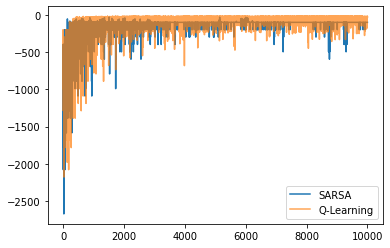

In [ ]:
plt.plot(episode_rewards_sarsa, label='SARSA')
plt.plot(episode_rewards_QL, label='Q-Learning', alpha=0.7)
plt.legend()
plt.show()